In [ ]:
!pip -q install xgboost lightgbm scikit-learn pandas numpy matplotlib

In [1]:
import warnings, io, csv, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit, cross_validate, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [10]:
CSV_PATH = "../1 data acqusition/Antam_historical_gold_prices.csv"

In [11]:
def load_indonesian_market_csv(csv_path: str) -> pd.DataFrame:
  try:
    raw = open(csv_path, "r", encoding="utf-8-sig").read()
  except UnicodeDecodeError:
    raw = open(csv_path, "r", encoding="latin-1").read()

  lines = [ln for ln in raw.splitlines() if ln.strip() != ""]
  sample = "\n".join(lines[:50])
  try:
    sep = csv.Sniffer().sniff(sample).delimiter
  except:
    sep = ";"  # common fallback for Indonesian CSVs

  text = "\n".join(lines)
  df = pd.read_csv(io.StringIO(text), sep=sep, engine="python")

  rename_map = {
        'Tanggal':'date','Date':'date','Waktu':'date',
        'Terakhir':'close','Penutupan':'close','Close':'close','Harga':'close','Last':'close',
        'Pembukaan':'open','Open':'open',
        'Tertinggi':'high','High':'high',
        'Terendah':'low','Low':'low',
        'Vol.':'volume','Volume':'volume',
        'Perubahan%':'change_pct','Perubahan %':'change_pct','Change %':'change_pct'
    }
  df = df.rename(columns={c: rename_map.get(c, c) for c in df.columns})

  if 'date' not in df.columns:
    df = df.rename(columns={df.columns[0]:'date'})
  if 'close' not in df.columns:
      price_candidates = [c for c in df.columns if c.lower() in
                              ['close','penutupan','terakhir','harga','last']]
      if price_candidates:
          df = df.rename(columns={price_candidates[0]:'close'})
      else:
          num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
          if len(num_cols)==0:
              raise ValueError("No numeric price column found. Rename your price column to Close/Terakhir/Penutupan.")
          df = df.rename(columns={num_cols[-1]:'close'})

  df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)

  def indo_to_float(s):
      s = str(s).strip().replace('%','')
      s = "".join(ch for ch in s if ch.isdigit() or ch in "-.,")
      s = s.replace(".", "").replace(",", ".")
      if s in ["", "-", ".", "-.", ".-"]:
          return np.nan
      try:
          return float(s)
      except:
          return np.nan

  for c in df.columns:
      if c == 'date':
          continue
      if df[c].dtype == object:
          conv = df[c].map(indo_to_float)
          if conv.notna().sum() > 0:
              df[c] = conv
  df = df.dropna(subset=['date','close']).sort_values('date').reset_index(drop=True)
  return df

df = load_indonesian_market_csv(CSV_PATH)
print("Data shape:", df.shape)
display(df.head())
display(df.tail())



Data shape: (1900, 3)


,Time (ms),close,date
0,1265014620000,403000,2010-01-02 08:57:00
1,1267427340000,404000,2010-01-03 07:09:00
2,1270111080000,397000,2010-01-04 08:38:00
3,1275386940000,425000,2010-01-06 10:09:00
4,1277974620000,427000,2010-01-07 08:57:00


,Time (ms),close,date
1895,1747038157000,1905000,2025-12-05 08:22:37
1896,1749716539000,1928000,2025-12-06 08:22:19
1897,1752308644000,1919000,2025-12-07 08:24:04
1898,1754986694000,1924000,2025-12-08 08:18:14
1899,1757665117000,2088000,2025-12-09 08:18:37


Date range: 2010-01-02 08:57:00 → 2025-12-09 08:18:37


,Time (ms),close,date
count,1.900000e+03,1.900000e+03,1900
mean,1.528906e+12,8.350351e+05,2018-06-14 07:19:44.588947200
min,1.262596e+12,3.970000e+05,2010-01-02 08:57:00
25%,1.409098e+12,5.700000e+05,2014-08-08 18:00:00
50%,1.538515e+12,6.660000e+05,2018-09-10 20:07:40
75%,1.656944e+12,9.950000e+05,2022-07-02 14:42:43.249999872
max,1.759824e+12,2.284000e+06,2025-12-09 08:18:37
std,1.449958e+11,3.731271e+05,NaN


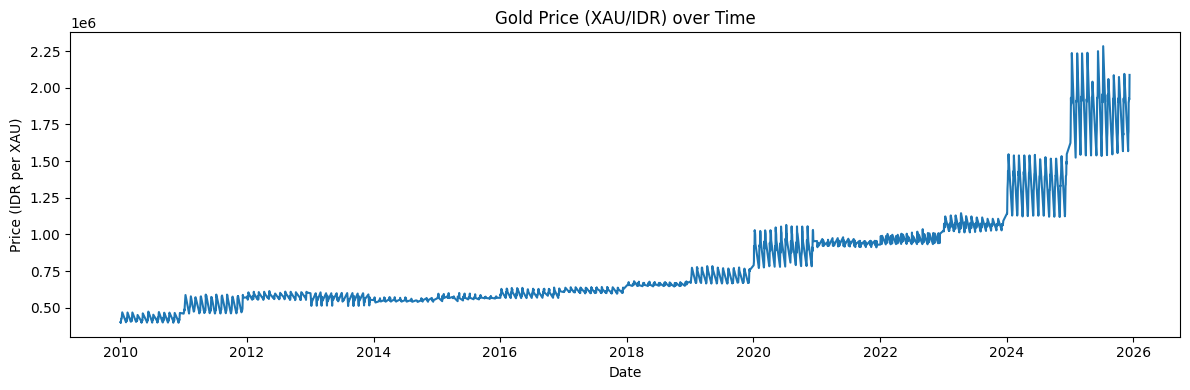

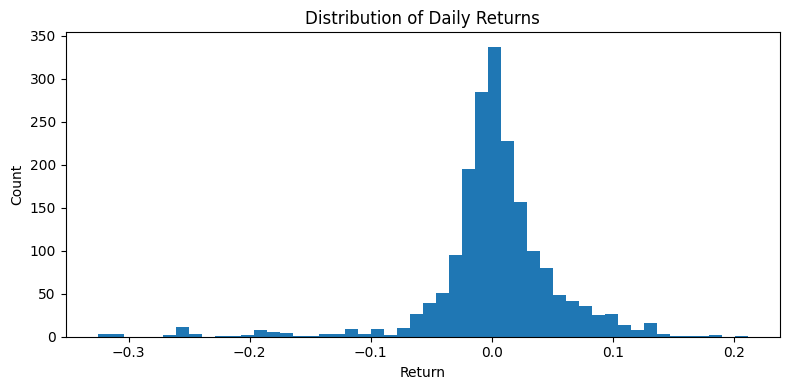

In [12]:
print("Date range:", df['date'].min(), "→", df['date'].max())
display(df.describe(include='all'))

plt.figure(figsize=(12,4))
plt.plot(df['date'], df['close'])
plt.title("Gold Price (XAU/IDR) over Time")
plt.xlabel("Date"); plt.ylabel("Price (IDR per XAU)")
plt.tight_layout(); plt.show()

df['ret'] = df['close'].pct_change()
plt.figure(figsize=(8,4))
plt.hist(df['ret'].dropna(), bins=50)
plt.title("Distribution of Daily Returns")
plt.xlabel("Return"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


In [14]:
def add_features_adaptive(data: pd.DataFrame, price='close') -> pd.DataFrame:
    out = data.copy()
    n = len(out)

    # guard: if < 5 rows, we can't build a model sensibly
    if n < 8:
        raise ValueError(f"Dataset too small after loading (n={n}). Add more rows.")

    out['ret'] = out[price].pct_change()
    out['log_ret'] = np.log1p(out['ret'])

    # choose lags/windows based on data length
    # keep them small for tiny datasets
    max_lag = max(1, min(5, n // 6))         # 1..5
    lag_list = list(range(1, max_lag + 1))   # e.g., [1,2,3]
    win_candidates = [3, 5, 10, 20]
    win_list = [w for w in win_candidates if w < n-2]
    if not win_list:
        win_list = [3]  # minimal

    for L in lag_list:
        out[f'ret_lag_{L}'] = out['ret'].shift(L)

    for w in win_list:
        out[f'roll_mean_{w}'] = out['ret'].rolling(w, min_periods=1).mean()
        out[f'roll_std_{w}']  = out['ret'].rolling(w, min_periods=1).std()
        out[f'roll_min_{w}']  = out['ret'].rolling(w, min_periods=1).min()
        out[f'roll_max_{w}']  = out['ret'].rolling(w, min_periods=1).max()

    # RSI with adaptive window
    rsi_w = max(3, min(14, n // 6))
    delta = out[price].diff()
    gain = (delta.where(delta > 0, 0.0)).rolling(rsi_w, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0.0)).rolling(rsi_w, min_periods=1).mean()
    rs = gain / (loss + 1e-9)
    out['rsi14'] = 100 - (100 / (1 + rs))

    # MACD: shorten spans if data is tiny
    fast = max(6, min(12, n // 5))
    slow = max(fast+4, min(26, n // 3))
    signal = max(5, min(9, n // 6))
    ema_fast = out[price].ewm(span=fast, adjust=False).mean()
    ema_slow = out[price].ewm(span=slow, adjust=False).mean()
    out['macd'] = ema_fast - ema_slow
    out['macd_signal'] = out['macd'].ewm(span=signal, adjust=False).mean()
    out['macd_hist'] = out['macd'] - out['macd_signal']

    # Bollinger (adaptive)
    bb_w = max(5, min(20, n // 4))
    ma = out[price].rolling(bb_w, min_periods=1).mean()
    sd = out[price].rolling(bb_w, min_periods=1).std()
    out['bb_mid'] = ma
    out['bb_up']  = ma + 2*sd
    out['bb_low'] = ma - 2*sd
    out['bb_width'] = (out['bb_up'] - out['bb_low']) / (out['bb_mid'] + 1e-9)

    # calendar
    out['dow'] = out['date'].dt.weekday
    out['month'] = out['date'].dt.month

    return out

feat = add_features_adaptive(df, price='close')

# Target = next-day direction
feat['next_close'] = feat['close'].shift(-1)
feat['target'] = (feat['next_close'] > feat['close']).astype(int)

# Drop only rows where target is NaN (last row) and where lags are NaN
# (initial few rows due to shift). With min_periods=1, most rollings are filled.
feat = feat.dropna(subset=['target'] + [c for c in feat.columns if c.startswith('ret_lag_')]).reset_index(drop=True)

feature_cols = [c for c in feat.columns if c not in ['date','close','next_close','target']]
X = feat[feature_cols]
y = feat['target']

print("Rows after features:", len(feat), "| Features:", len(feature_cols))
print("First/last dates:", feat['date'].iloc[0], "→", feat['date'].iloc[-1])


Rows after features: 1894 | Features: 34
First/last dates: 2010-01-10 08:04:00 → 2025-12-09 08:18:37


In [15]:
n = len(feat)
min_side = 20 if n >= 120 else max(5, n // 5)  # smaller datasets → smaller holdout
split_idx = max(min_side, n - min_side)        # keep both sides non-empty

# if extremely small, use 80/20
split_idx = max(1, min(n-1, int(n * 0.8)))     # final guard

X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_test,  y_test  = X.iloc[split_idx:], y.iloc[split_idx:]

print(f"Train: {X_train.shape}  Test: {X_test.shape}")

# Choose n_splits that fits the train size (each split needs >= 2 samples)
from sklearn.model_selection import TimeSeriesSplit
max_splits = max(2, min(5, len(X_train) // 5))  # ~5 folds if enough data
tscv = TimeSeriesSplit(n_splits=max_splits)
print("TimeSeries CV splits:", tscv.n_splits)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

gb = GradientBoostingClassifier(random_state=42)
pipe_gb = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", gb)])

scoring = {"accuracy":"accuracy", "f1":"f1", "roc_auc":"roc_auc", "avg_prec":"average_precision"}

# If training set is tiny (< tscv.n_splits samples), skip CV and just fit
if len(X_train) <= tscv.n_splits:
    print("Train set very small; skipping CV.")
    pipe_gb.fit(X_train, y_train)
    pred_gb = pipe_gb.predict(X_test)
    proba_gb = pipe_gb.predict_proba(X_test)[:,1]
else:
    cv_gb = cross_validate(pipe_gb, X_train, y_train, cv=tscv, scoring=scoring, n_jobs=-1)
    print("GB CV | Acc:", cv_gb['test_accuracy'].mean().round(4),
          "F1:", cv_gb['test_f1'].mean().round(4),
          "ROC-AUC:", cv_gb['test_roc_auc'].mean().round(4),
          "AP:", cv_gb['test_avg_prec'].mean().round(4))
    pipe_gb.fit(X_train, y_train)
    pred_gb = pipe_gb.predict(X_test)
    proba_gb = pipe_gb.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, f1_score, classification_report
acc = accuracy_score(y_test, pred_gb)
f1  = f1_score(y_test, pred_gb)

print(f"\nHoldout (GB):  Acc: {acc:.4f}   F1: {f1:.4f}")
print(classification_report(y_test, pred_gb, digits=4))


Train: (1515, 34)  Test: (379, 34)
TimeSeries CV splits: 5
GB CV | Acc: 0.6516 F1: 0.6398 ROC-AUC: 0.7378 AP: 0.7087

Holdout (GB):  Acc: 0.6491   F1: 0.6871
              precision    recall  f1-score   support

           0     0.4926    0.7692    0.6006       130
           1     0.8295    0.5863    0.6871       249

    accuracy                         0.6491       379
   macro avg     0.6611    0.6778    0.6438       379
weighted avg     0.7140    0.6491    0.6574       379



This is a detailed summary of the variables, objects, and their respective types and values currently defined in your Jupyter Notebook environment. It provides an overview of the data structures, machine learning models, pipelines, and other objects that are being used in your workflow.

For example:
- **`feature_cols`**: A list of feature names used for training the models.
- **`gb`, `lgb`, `xgb`**: Gradient Boosting, LightGBM, and XGBoost classifiers, respectively.
- **`pipe_gb`, `pipe_lgb`, `pipe_xgb`**: Pipelines that include preprocessing steps and the respective models.
- **`param_xgb`, `param_lgb`**: Hyperparameter grids for XGBoost and LightGBM models.
- **`y_train`, `y_test`**: Training and testing target labels.
- **`proba_gb`, `proba_lgb`, `proba_xgb`**: Predicted probabilities from the respective models.

This information is useful for debugging, documentation, or understanding the current state of your notebook.

In [16]:
xgb = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', tree_method='hist', n_estimators=300)
pipe_xgb = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", xgb)])
param_xgb = {
    "model__max_depth": [2,3,4,5,6],
    "model__learning_rate": np.linspace(0.01, 0.2, 10),
    "model__subsample": np.linspace(0.6, 1.0, 5),
    "model__colsample_bytree": np.linspace(0.6, 1.0, 5),
    "model__min_child_weight": [1,3,5,7]
}
rs_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_xgb, n_iter=25,
                            scoring="f1", cv=tscv, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
rs_xgb.fit(X_train, y_train)
pred_xgb = rs_xgb.best_estimator_.predict(X_test)
proba_xgb = rs_xgb.best_estimator_.predict_proba(X_test)[:,1]
print("XGB best params:", rs_xgb.best_params_)
print("XGB Holdout | Acc:", round(accuracy_score(y_test, pred_xgb), 4),
      "F1:", round(f1_score(y_test, pred_xgb), 4))

# LightGBM
lgb = LGBMClassifier(random_state=RANDOM_STATE, n_estimators=500)
pipe_lgb = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", lgb)])
param_lgb = {
    "model__num_leaves": [15,31,63,127],
    "model__learning_rate": np.linspace(0.01, 0.2, 10),
    "model__subsample": np.linspace(0.6, 1.0, 5),
    "model__colsample_bytree": np.linspace(0.6, 1.0, 5),
    "model__min_child_samples": [10,20,30,50]
}
rs_lgb = RandomizedSearchCV(pipe_lgb, param_distributions=param_lgb, n_iter=25,
                            scoring="f1", cv=tscv, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
rs_lgb.fit(X_train, y_train)
pred_lgb = rs_lgb.best_estimator_.predict(X_test)
proba_lgb = rs_lgb.best_estimator_.predict_proba(X_test)[:,1]
print("LGB best params:", rs_lgb.best_params_)
print("XGB Holdout | Acc:", round(accuracy_score(y_test, pred_xgb), 4),
      "F1:", round(f1_score(y_test, pred_xgb), 4))



XGB best params: {'model__subsample': np.float64(1.0), 'model__min_child_weight': 1, 'model__max_depth': 6, 'model__learning_rate': np.float64(0.03111111111111111), 'model__colsample_bytree': np.float64(0.7)}
XGB Holdout | Acc: 0.6016 F1: 0.6361
[LightGBM] [Info] Number of positive: 736, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7740
[LightGBM] [Info] Number of data points in the train set: 1515, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485809 -> initscore=-0.056781
[LightGBM] [Info] Start training from score -0.056781
LGB best params: {'model__subsample': np.float64(0.6), 'model__num_leaves': 15, 'model__min_child_samples': 20, 'model__learning_rate': np.float64(0.052222222222222225), 'model__colsample_bytree': np.float64(1.0)}
XGB Holdout | Acc: 0.6016 F1: 0.6361


Best by default threshold 0.5 → GB (F1=0.6871)
Best threshold=0.300, F1=0.7604


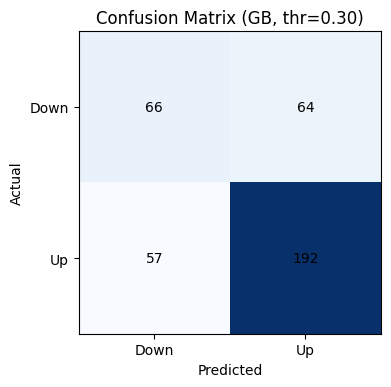

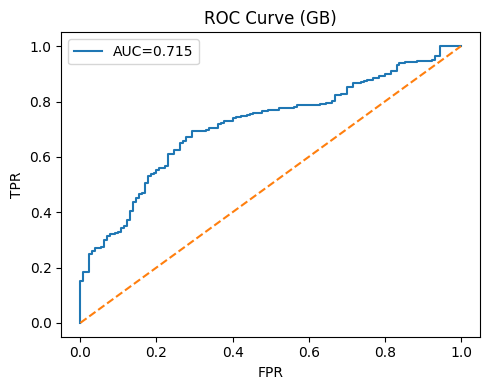

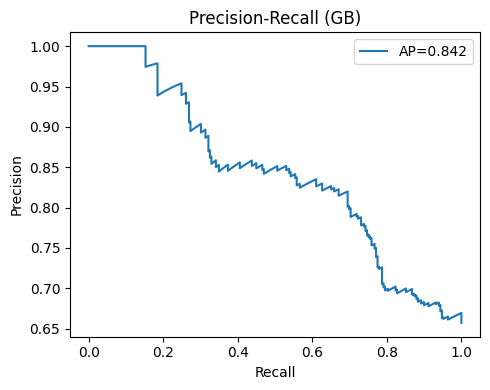

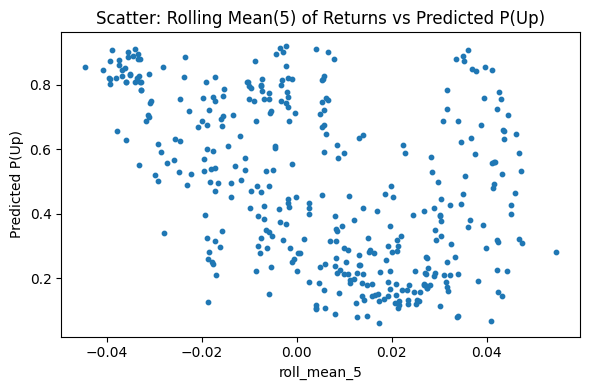

In [17]:
cands = {
    'GB': (pred_gb, proba_gb, pipe_gb),
    'XGB': (pred_xgb, proba_xgb, rs_xgb.best_estimator_),
    'LGB': (pred_lgb, proba_lgb, rs_lgb.best_estimator_)
}

best_name, best_pred, best_proba, best_pipe, best_f1 = None, None, None, None, -1
for name, (p, pr, model) in cands.items():
    f1 = f1_score(y_test, p)
    if f1 > best_f1:
        best_name, best_pred, best_proba, best_pipe, best_f1 = name, p, pr, model, f1

print(f"Best by default threshold 0.5 → {best_name} (F1={best_f1:.4f})")

# Tune threshold for best F1 on holdout
thresh_grid = np.linspace(0.3, 0.7, 41)
best_thresh, best_f1_thr = 0.5, -1
for t in thresh_grid:
    f1 = f1_score(y_test, (best_proba >= t).astype(int))
    if f1 > best_f1_thr:
        best_f1_thr, best_thresh = f1, t
print(f"Best threshold={best_thresh:.3f}, F1={best_f1_thr:.4f}")

# Confusion matrix @ tuned threshold
cm = confusion_matrix(y_test, (best_proba >= best_thresh).astype(int))
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title(f'Confusion Matrix ({best_name}, thr={best_thresh:.2f})')
plt.xticks([0,1], ['Down','Up']); plt.yticks([0,1], ['Down','Up'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.tight_layout(); plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, best_proba)
roc_auc = roc_auc_score(y_test, best_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.title(f'ROC Curve ({best_name})'); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.legend(); plt.tight_layout(); plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, best_proba)
ap = average_precision_score(y_test, best_proba)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f'AP={ap:.3f}')
plt.title(f'Precision-Recall ({best_name})'); plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(); plt.tight_layout(); plt.show()

# Scatter: rolling mean vs predicted P(Up)
viz = pd.DataFrame({
    'date': feat['date'].iloc[len(X_train):].values,
    'roll_mean_5': feat['roll_mean_5'].iloc[len(X_train):].values,
    'proba_up': best_proba
}).dropna()

plt.figure(figsize=(6,4))
plt.scatter(viz['roll_mean_5'], viz['proba_up'], s=10)
plt.title('Scatter: Rolling Mean(5) of Returns vs Predicted P(Up)')
plt.xlabel('roll_mean_5'); plt.ylabel('Predicted P(Up)')
plt.tight_layout(); plt.show()

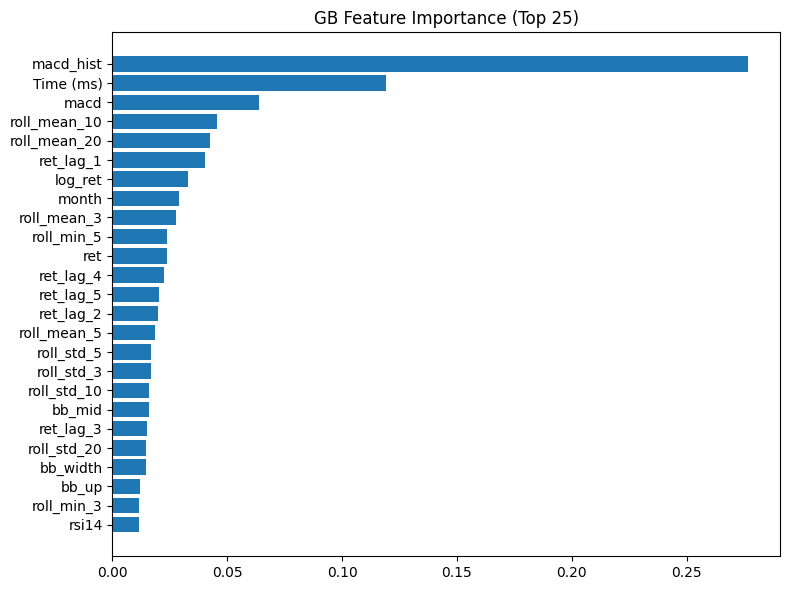

['best_model_GB.joblib']

In [18]:
def plot_importance_from_pipeline(pipeline, feat_cols, title):
    model = pipeline.named_steps.get('model', pipeline)
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
    elif hasattr(model, 'booster_') and hasattr(model.booster_, 'feature_importances_'):
        imp = model.booster_.feature_importances_
    else:
        print("No feature_importances_ found."); return
    order = np.argsort(imp)[::-1][:25]
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feat_cols)[order][::-1], imp[order][::-1])
    plt.title(title); plt.tight_layout(); plt.show()

plot_importance_from_pipeline(best_pipe, X.columns, f"{best_name} Feature Importance (Top 25)")
dump(best_pipe, f'best_model_{best_name}.joblib')

In [19]:
best_pipe.fit(X, y)   # refit on all labeled data
last_X = X.iloc[[-1]]
p_up = float(best_pipe.predict_proba(last_X)[:,1])
pred = int(p_up >= best_thresh)
direction = "UP 📈" if pred==1 else "DOWN 📉"
print(f"Next-day projection: {direction}  |  P(Up)={p_up:.3f}  |  threshold={best_thresh:.3f}")

# Save artifacts
dump(best_pipe, "gold_direction_model.joblib")
pd.DataFrame({
    "date": feat['date'].iloc[len(X_train):].values,
    "actual": y_test.values,
    f"pred@{best_thresh:.2f}": (best_proba>=best_thresh).astype(int),
    "proba_up": best_proba
}).to_csv("holdout_predictions.csv", index=False)

Next-day projection: DOWN 📉  |  P(Up)=0.215  |  threshold=0.300
